In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pathlib import Path
from collections import defaultdict

###
# Recreation of Jegadessh and Titman's (1993) momentum strategy
# Returns to Buying Winners and Selling Losers: Implications for Stock Market Efficiency
# based on current stock price data.
# This script implements a momentum-based trading strategy using stock price data.
###

# Fetch current S&P 100 tickers
url = "https://en.wikipedia.org/wiki/S%26P_100"
table = pd.read_html(url, match="Symbol")[0]

# Convert to Yahoo's format
def fix_ticker(t):
    return t.replace('.', '-') if isinstance(t, str) else t

tickers = table['Symbol'].unique().tolist()
tickers = [fix_ticker(t) for t in tickers]

# Download 10 years of monthly close prices
print("Downloading stock price data...")
price_data = yf.download(
    tickers=tickers,
    period="10y",
    interval="1mo",
    auto_adjust=True,
    progress=False,
    threads=True
)

# Use Close prices, filter out stocks with too many missing values
monthly_prices = price_data["Close"]
monthly_prices = monthly_prices.dropna(axis=1, thresh=int(0.8 * len(monthly_prices)))
monthly_returns = monthly_prices.pct_change().dropna()

In [38]:
params = [3, 6, 9, 12]
results = {}
output_dir = Path("momentum_results")
output_dir.mkdir(exist_ok=True)

for J in params:
    for K in params:
        print(f"Processing J={J}, K={K}")
        try:
            portfolio_returns = defaultdict(list)
            rebalance_dates = monthly_prices.index[J:-(K - 1)]  # Ensure lookback and holding period are valid

            for i, date in enumerate(rebalance_dates):
                try:
                    # Define lookback period
                    start_date = monthly_prices.index[i]
                    end_date = monthly_prices.index[i + J - 1]

                    # Price change for momentum ranking
                    past_price = monthly_prices.loc[start_date]
                    recent_price = monthly_prices.loc[end_date]

                    momentum = (recent_price / past_price) - 1
                    momentum = momentum.dropna()

                    # Rank by momentum and bin into deciles
                    ranked = momentum.rank(pct=True)
                    deciles = pd.qcut(ranked, 10, labels=False)

                    # Holding period: from i + J to i + J + K - 1
                    hold_start_idx = i + J
                    hold_end_idx = i + J + K - 1
                    if hold_end_idx >= len(monthly_prices.index):
                        continue

                    hold_start = monthly_prices.index[hold_start_idx]
                    hold_end = monthly_prices.index[hold_end_idx]

                    start_prices = monthly_prices.loc[hold_start]
                    end_prices = monthly_prices.loc[hold_end]

                    # Raw K-month returns
                    k_month_returns = (end_prices / start_prices) - 1
                    k_month_returns = k_month_returns.dropna()

                    port_ret = {}
                    for decile in range(10):
                        stocks = momentum.index[deciles == decile]
                        valid_stocks = [s for s in stocks if s in k_month_returns.index]
                        if len(valid_stocks) == 0:
                            continue

                        gross_return = k_month_returns.loc[valid_stocks].mean()
                        
                        # Convert K-month return to monthly equivalent
                        monthlyized_return = (1 + gross_return) ** (1 / K) - 1
                        port_ret[decile + 1] = monthlyized_return

                    for decile, ret in port_ret.items():
                        # Store using the end of the holding period as timestamp
                        portfolio_returns[(hold_end, decile)].append(ret)

                except Exception as e:
                    print(f"Error at {date.date()} for J={J}, K={K}: {e}")

            # Build DataFrame of results
            final_data = []
            for (date, decile), rets in portfolio_returns.items():
                final_data.append({
                    "Date": date,
                    "Decile": decile,
                    "Return": np.mean(rets)
                })

            portfolio_df = pd.DataFrame(final_data)
            portfolio_df = portfolio_df.sort_values("Date")
            
            results[(J, K)] = portfolio_df

            # Save to CSV
            output_file = output_dir / f"momentum_J{J}_K{K}.csv"
            portfolio_df.to_csv(output_file, index=False)

        except Exception as e:
            print(f"Failed processing for J={J}, K={K}: {e}")

Processing J=3, K=3
Processing J=3, K=6
Processing J=3, K=9
Processing J=3, K=12
Processing J=6, K=3
Processing J=6, K=6
Processing J=6, K=9
Processing J=6, K=12
Processing J=9, K=3
Processing J=9, K=6
Processing J=9, K=9
Processing J=9, K=12
Processing J=12, K=3
Processing J=12, K=6
Processing J=12, K=9
Processing J=12, K=12


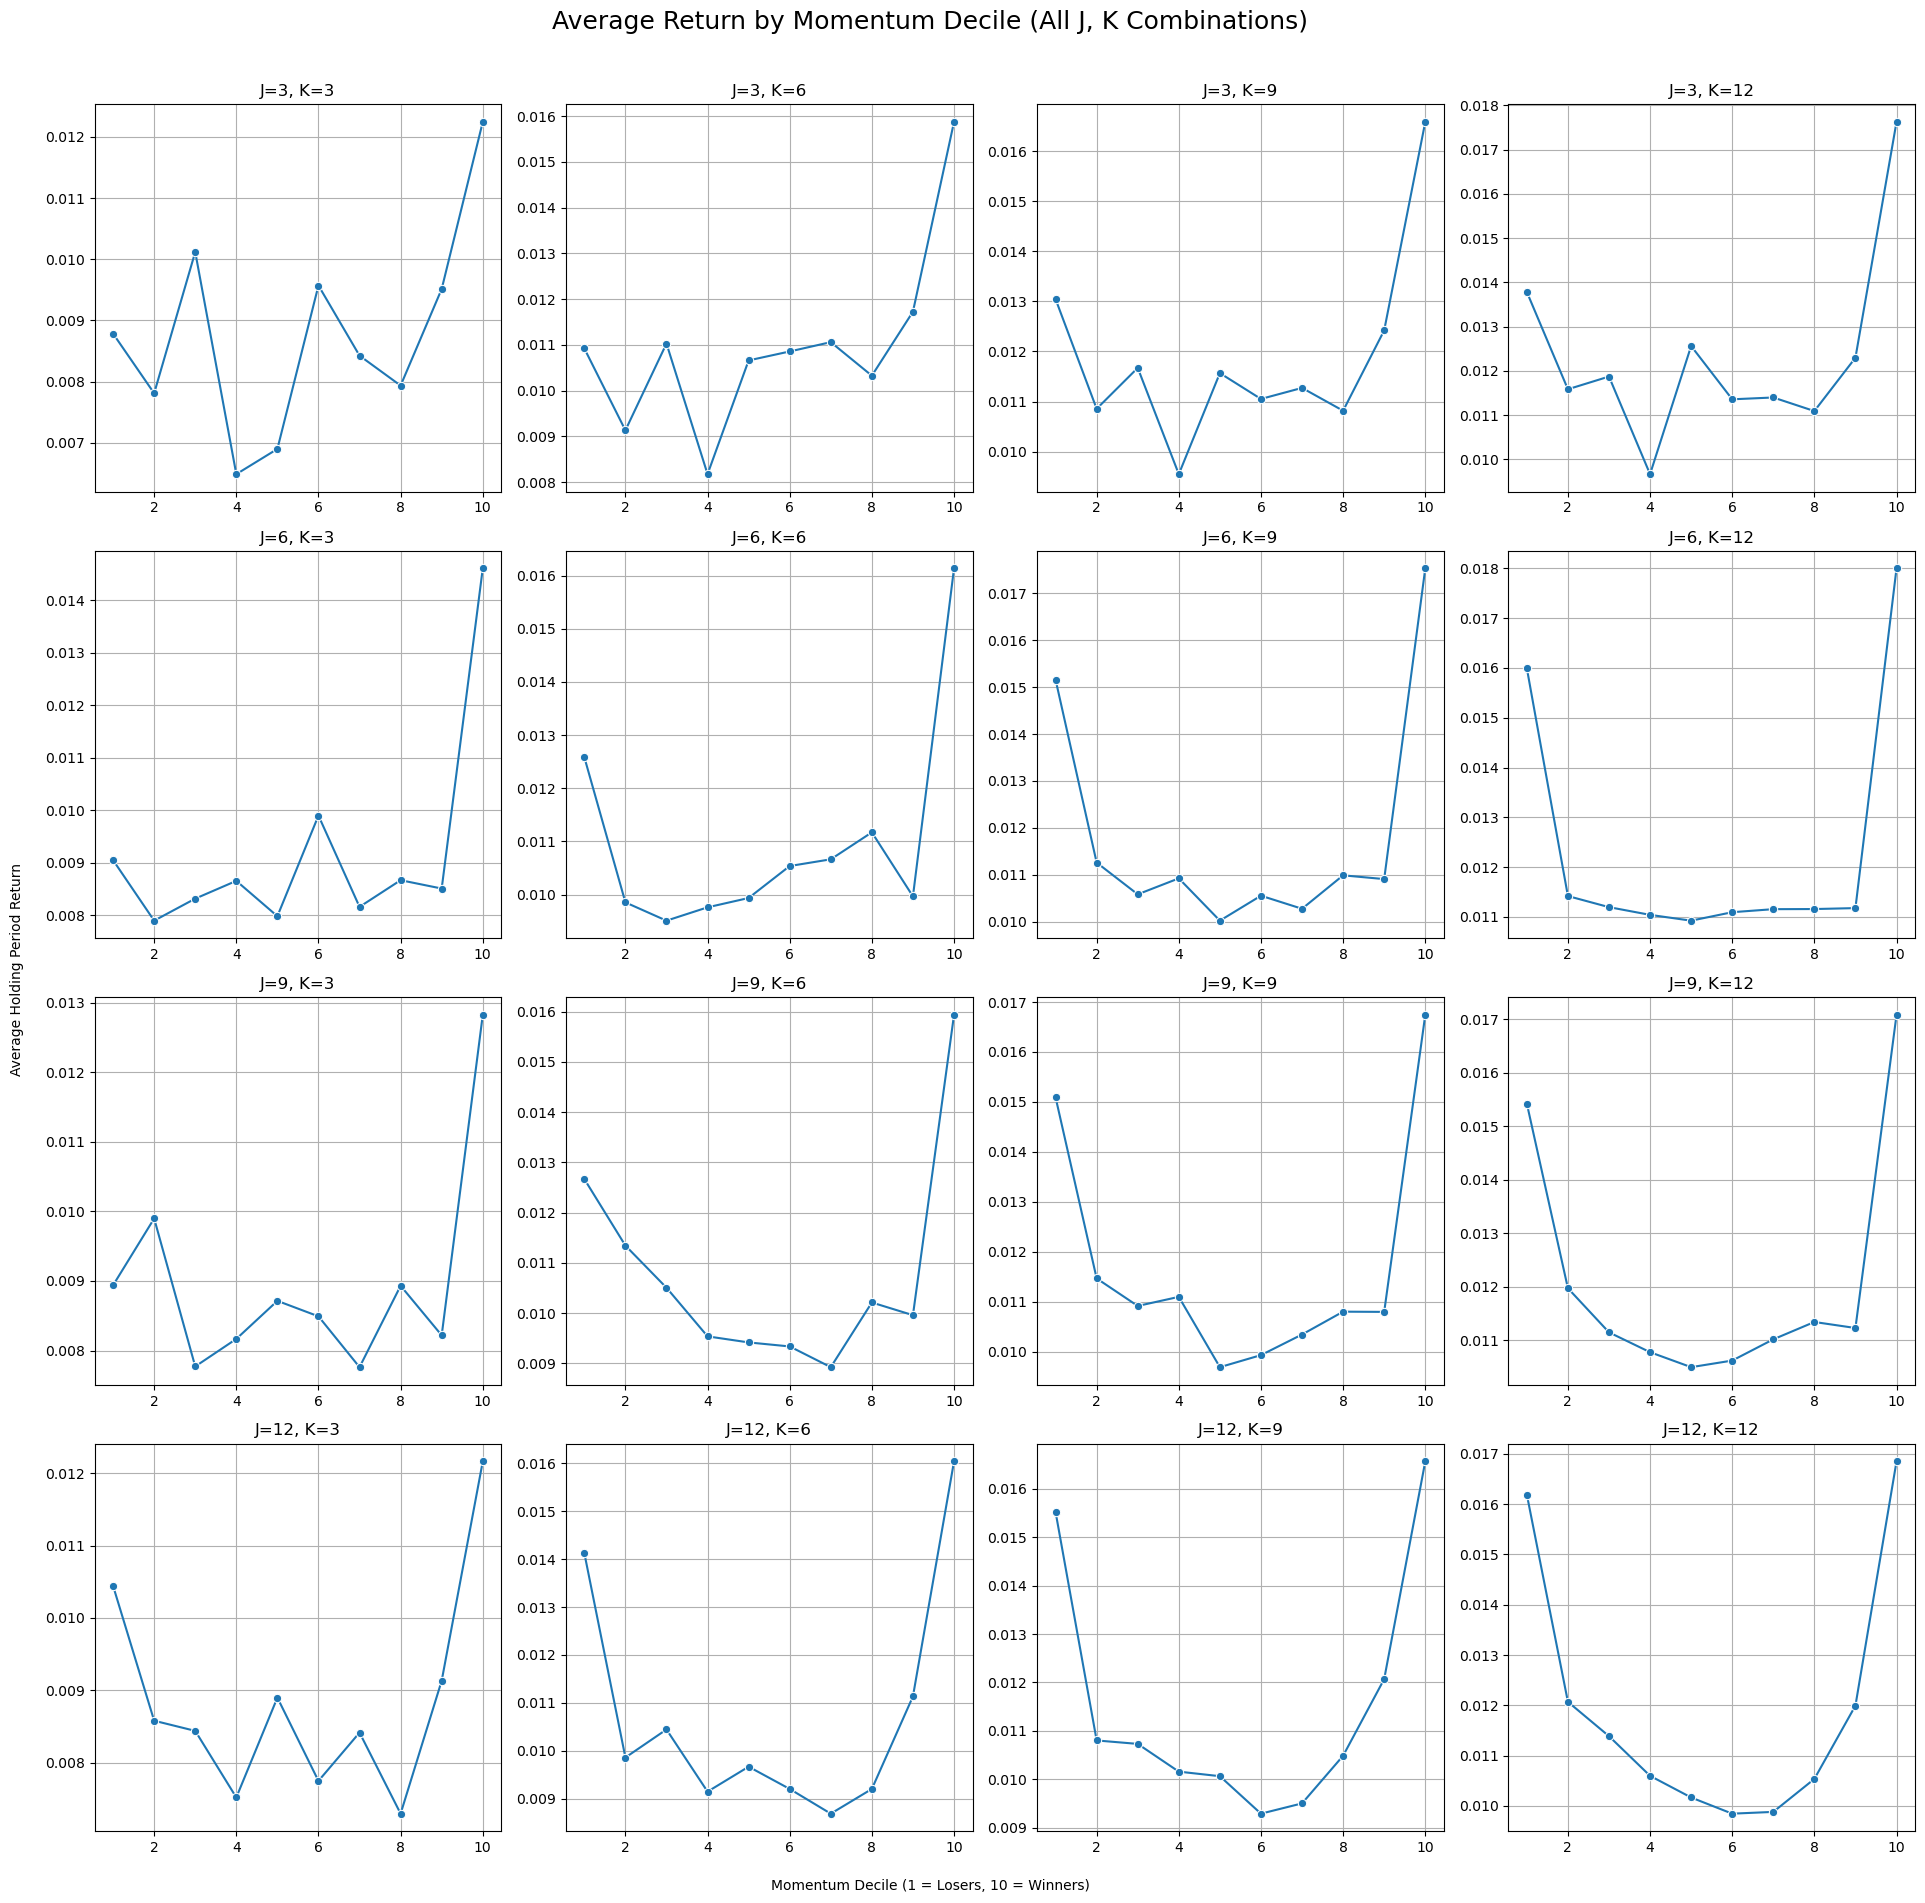

In [39]:
combos = [(j, k) for j in params for k in params]

# Average Return per Decile Plot
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle("Average Return by Momentum Decile (All J, K Combinations)", fontsize=18)

for i, (j, k) in enumerate(combos):
    row, col = divmod(i, 4)
    ax = axs[row, col]
    df = results.get((j, k))
    if df is not None:
        avg_returns = df.groupby("Decile")["Return"].mean().reset_index()
        sns.lineplot(data=avg_returns, x="Decile", y="Return", marker="o", ax=ax)
        ax.set_title(f"J={j}, K={k}")
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(True)

fig.text(0.5, 0.04, "Momentum Decile (1 = Losers, 10 = Winners)", ha='center')
fig.text(0.04, 0.5, "Average Holding Period Return", va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 0.97])
plt.savefig(output_dir / "grid_avg_return_by_decile.png")
plt.show()
plt.close()

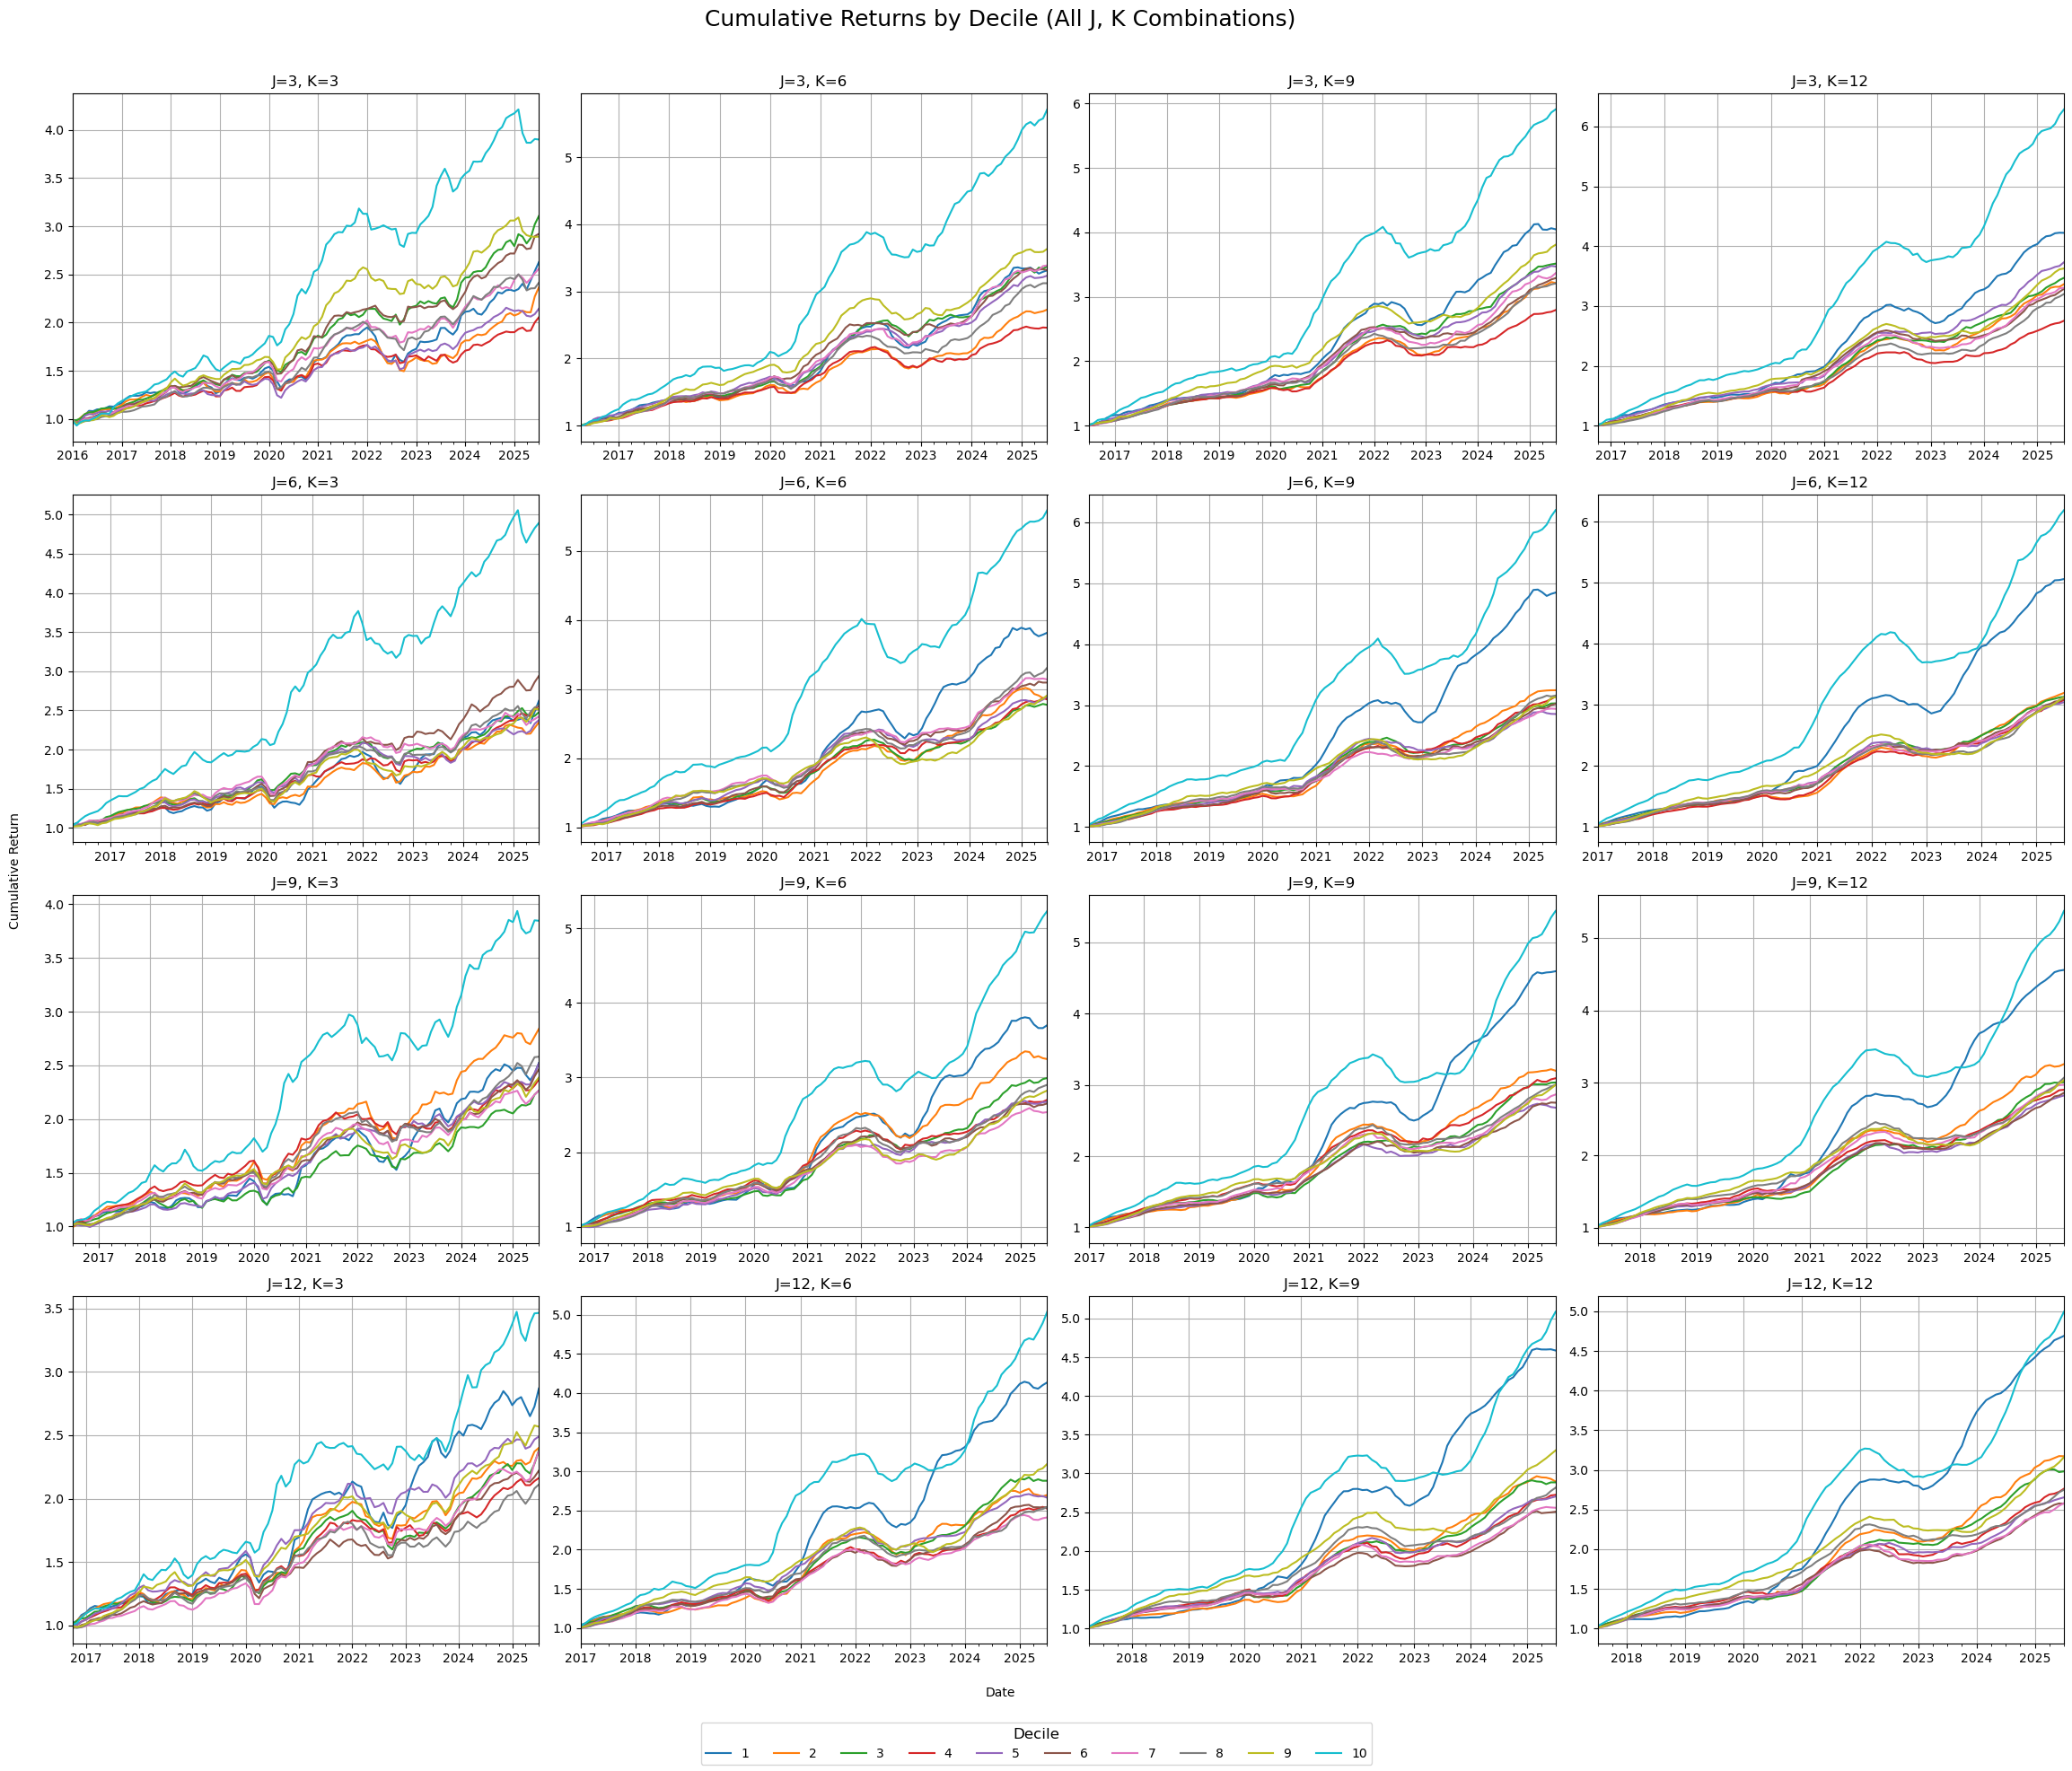

In [40]:
fig, axs = plt.subplots(4, 4, figsize=(24, 20), sharex=False, sharey=False)
fig.suptitle("Cumulative Returns by Decile (All J, K Combinations)", fontsize=18)

for i, (j, k) in enumerate(combos):
    row, col = divmod(i, 4)
    ax = axs[row, col]
    df = results.get((j, k))
    if df is not None:
        # Use raw returns only, not "Cumulative Return" column
        return_pivot = df.pivot(index="Date", columns="Decile", values="Return")
        return_pivot = return_pivot.fillna(0)

        # Compute cumulative return for plotting
        cumulative_returns = (1 + return_pivot).cumprod()

        cumulative_returns.plot(ax=ax, legend=False, colormap="tab10")
        ax.set_title(f"J={j}, K={k}")
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(True)

# Legend and layout
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=10, title='Decile', fontsize='medium', title_fontsize='large')

fig.text(0.5, 0.04, "Date", ha='center')
fig.text(0.04, 0.5, "Cumulative Return", va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 0.97])
plt.savefig(output_dir / "grid_cumulative_returns_by_decile.png")
plt.show()
plt.close()


In [41]:
# Risk-free rate — assume 0.04 annually
annual_rf_rate = 0.04
monthly_rf_rate = (1 + annual_rf_rate) ** (1 / 12) - 1

sharpe_results = {}

for (J, K), df in results.items():
    try:
        # Filter out 'Long-Short' decile from Sharpe calculation
        df_filtered = df[df["Decile"].apply(lambda x: isinstance(x, int))]

        grouped = df_filtered.groupby("Decile")["Return"]
        stats = grouped.agg([
            ('Mean Monthly Return', 'mean'),
            ('Std Dev', 'std'),
            ('Count', 'count')
        ])

        # Monthly Sharpe ratio
        stats["Sharpe (Monthly)"] = (stats["Mean Monthly Return"] - monthly_rf_rate) / stats["Std Dev"]

        # Annualized Sharpe = Monthly Sharpe * sqrt(12)
        stats["Sharpe (Annualized)"] = stats["Sharpe (Monthly)"] * np.sqrt(12)

        # Store
        sharpe_results[(J, K)] = stats

        # Optional: save to CSV
        stats.to_csv(output_dir / f"sharpe_J{J}_K{K}.csv")

    except Exception as e:
        print(f"Error computing Sharpe for J={J}, K={K}: {e}")

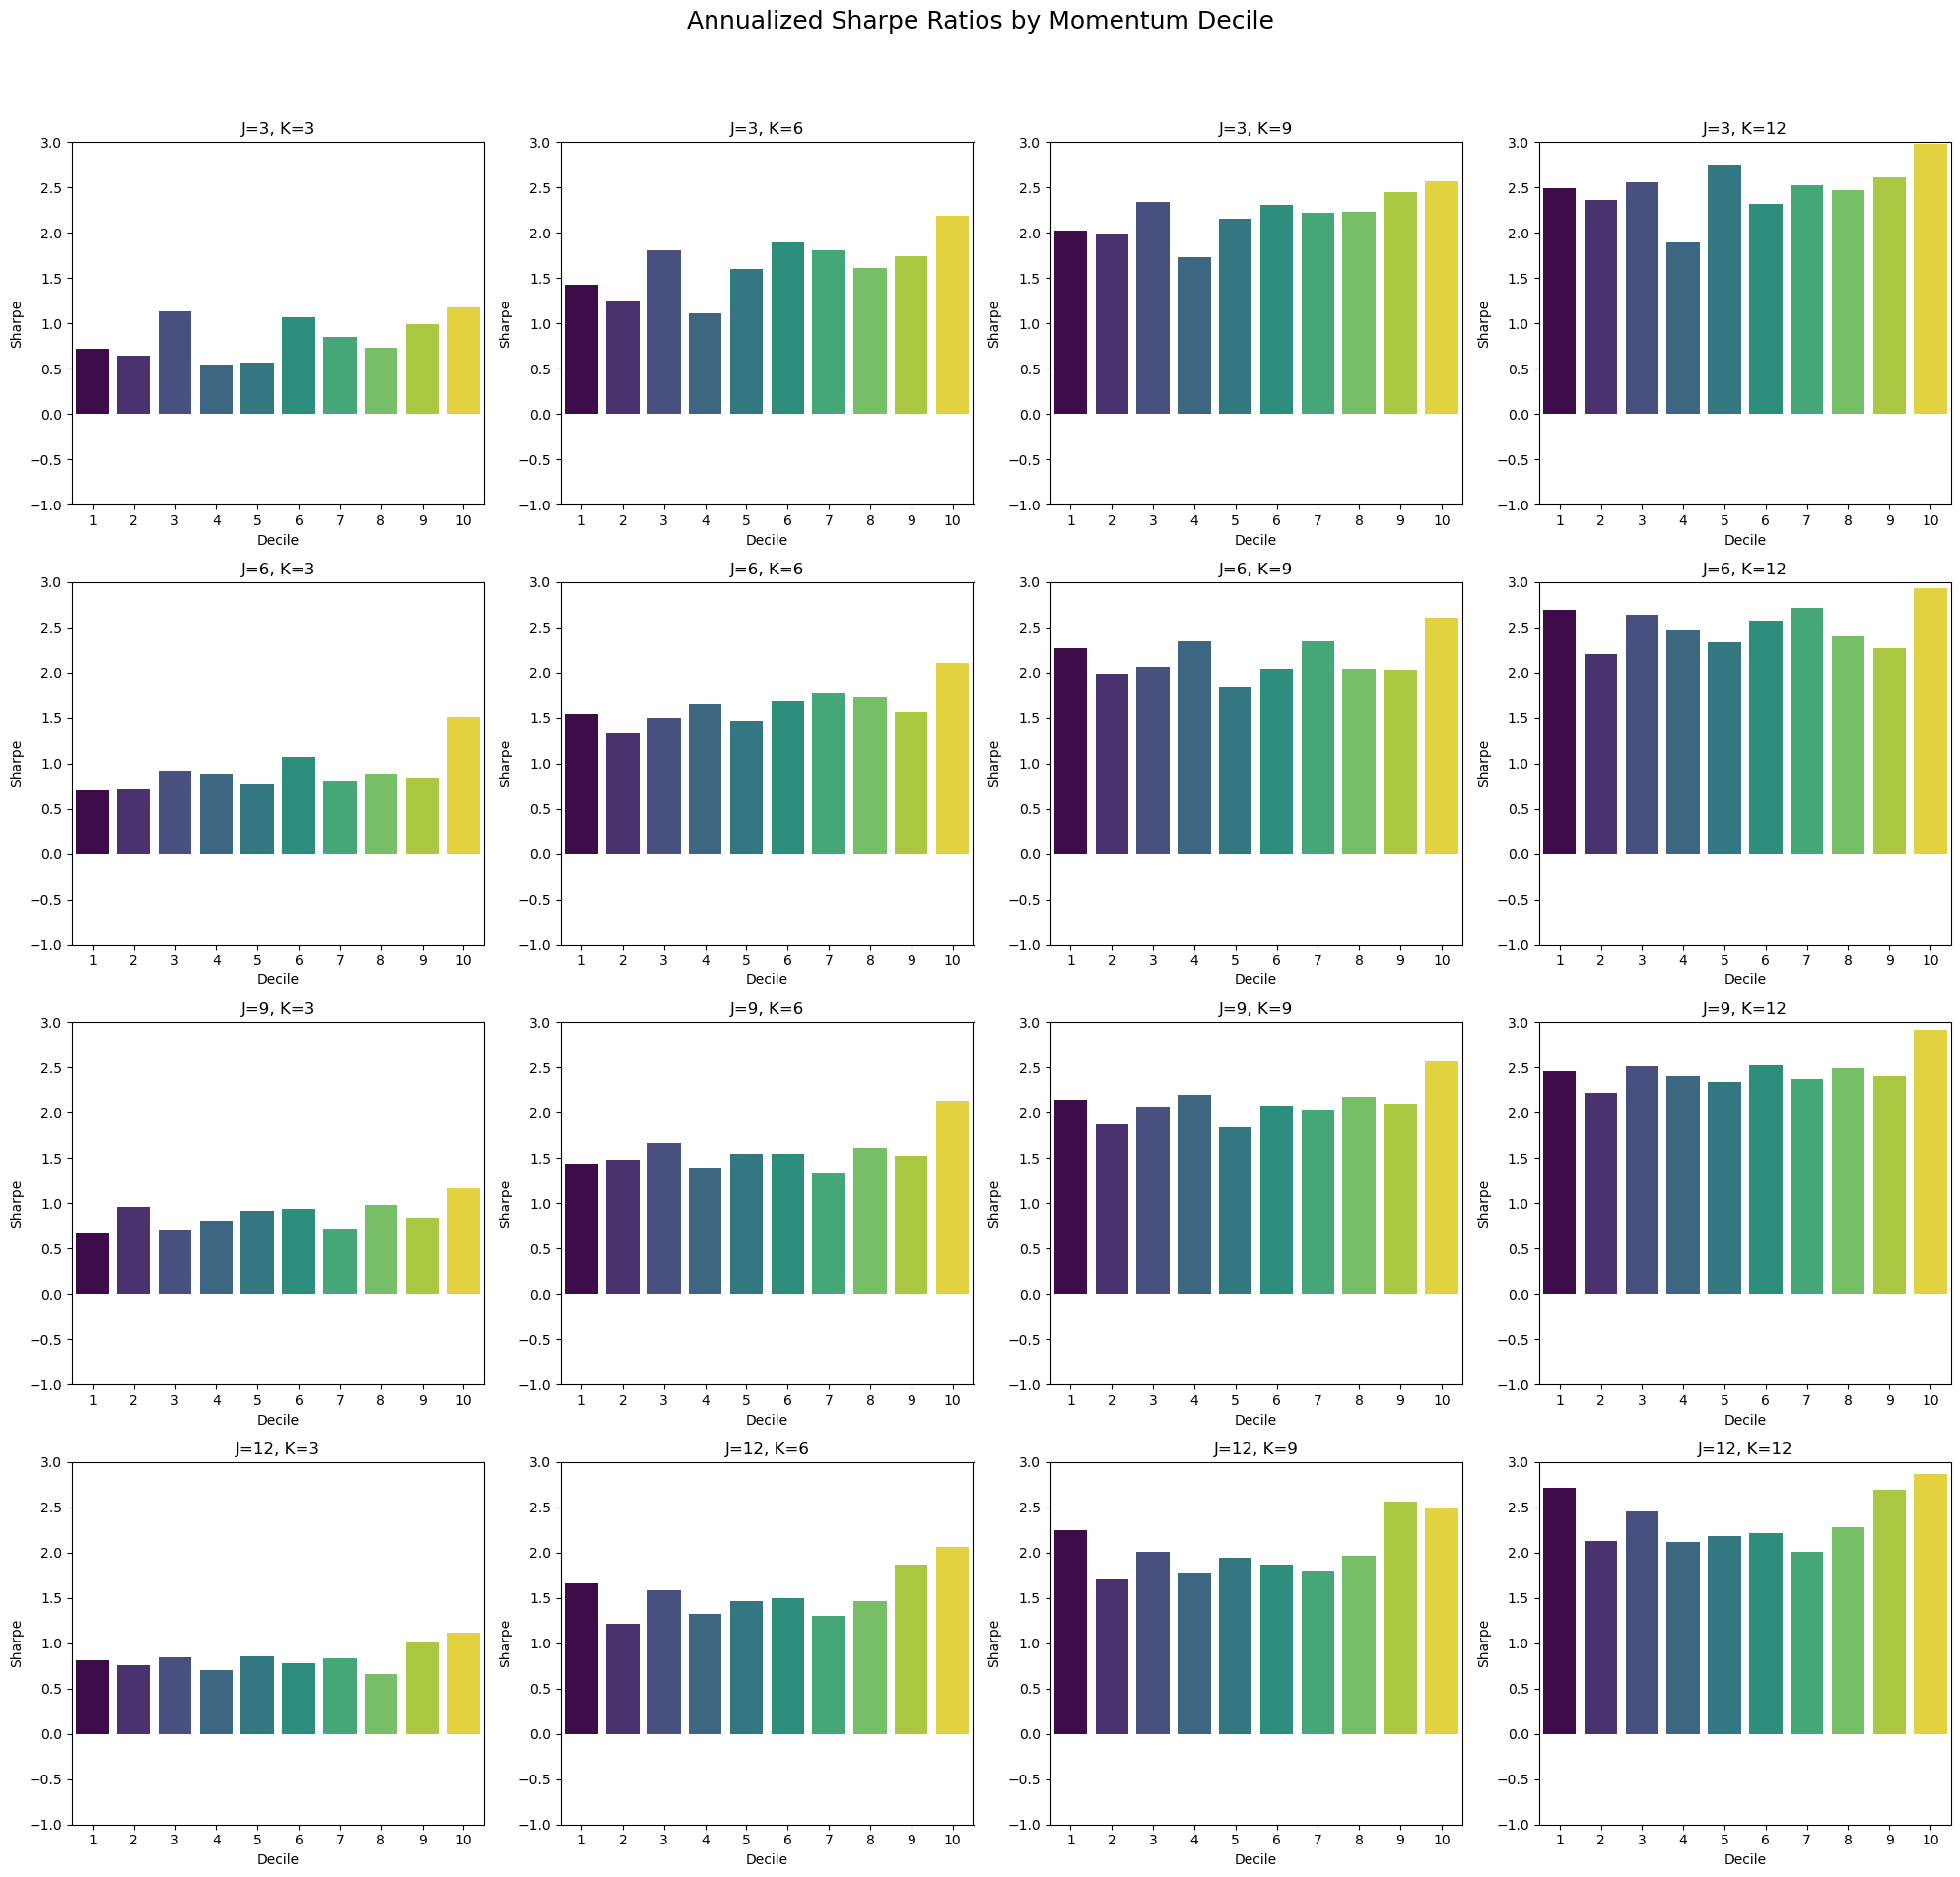

In [42]:
# Plotting Sharpe ratios (excluding long-short)
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle("Annualized Sharpe Ratios by Momentum Decile", fontsize=18)

for i, (J, K) in enumerate(sorted(sharpe_results.keys())):
    row, col = divmod(i, 4)
    ax = axs[row, col]
    stats = sharpe_results[(J, K)]

    sns.barplot(
        x=stats.index,
        y=stats["Sharpe (Annualized)"],
        ax=ax,
        hue=stats.index,  # Fix warning by assigning hue
        legend=False,
        palette="viridis"
    )

    ax.set_title(f"J={J}, K={K}")
    ax.set_ylim(-1, 3)
    ax.set_xlabel("Decile")
    ax.set_ylabel("Sharpe")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(output_dir / "sharpe_by_decile.png")
plt.show()


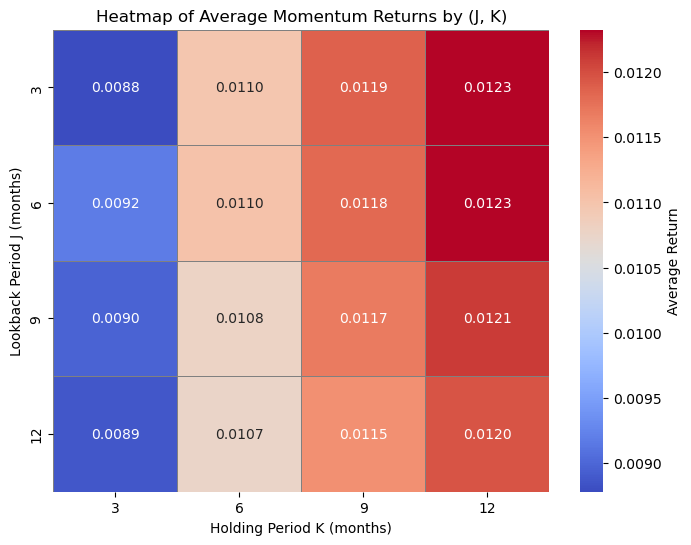

In [44]:
# Prepare a DataFrame to store average returns for each (J,K)
heatmap_data = pd.DataFrame(index=params, columns=params, dtype=float)

for (J, K), df in results.items():
    # Filter only deciles 1-10 (ignore long-short)
    df_deciles = df[df["Decile"].apply(lambda x: isinstance(x, int))]
    avg_return = df_deciles["Return"].mean()
    heatmap_data.loc[J, K] = avg_return

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="coolwarm",
    cbar_kws={"label": "Average Return"},
    linewidths=0.5,
    linecolor="gray"
)
plt.title("Heatmap of Average Momentum Returns by (J, K)")
plt.xlabel("Holding Period K (months)")
plt.ylabel("Lookback Period J (months)")
plt.show()